In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
# import matplotlib.pyplot as plt

# Finding license plate in an image

In [2]:
plate_model = tf.saved_model.load(r"../Pretrained/mobilenet_320_exported/saved_model")

In [3]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    orig_h, orig_w = image.shape[:2]
    image = cv2.resize(image, (320, 320))  # Resize to match model's input size
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image, orig_h, orig_w

In [4]:
def locate_plates(img_path):
    image, orig_h, orig_w = preprocess_image(img_path)
    orig_img = cv2.imread(image_path)
    predictions = plate_model(image)
    boxes = predictions['detection_boxes'][0].numpy()
    scores = predictions['detection_scores'][0].numpy()
    _, h, w, _ = image.shape
    plates = []
    for i in range(len(scores)):
        if scores[i] > 0.3:  # Only consider detections with high confidence
            box = boxes[i]
            # Scale the bounding box coordinates up to the original image size
            startY, startX, endY, endX = box
            startX, startY, endX, endY = (startX * orig_w, startY * orig_h, endX * orig_w, endY * orig_h)
            startX, startY, endX, endY = int(startX), int(startY), int(endX), int(endY)
            plates.append(orig_img[startY:endY, startX:endX].copy())
            # cv2.imwrite(f"Plates//plate{i}.jpg", plate)
            # cv2.rectangle(orig_img, (startX, startY), (endX, endY), (0, 255, 0), 2)
    return plates, (orig_img, startX, startY, endX, endY)

In [5]:
image_path = r"../testing/122333042_1376562146069578_1050128285588888549_n.jpg"
plates, (orig_img, startX, startY, endX, endY) = locate_plates(image_path)

# Digits seperation

In [6]:
def apply_hsv_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    blur_hsv = cv2.GaussianBlur(hsv, (11,11), cv2.BORDER_DEFAULT)
    upper = np.array([40, 255, 255])
    lower = np.array([10, 0, 0])
    mask = cv2.inRange(blur_hsv, lower, upper)
    return cv2.bitwise_and(img, img, mask=mask)

In [7]:
def apply_thresh(img, blur_p=11):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (blur_p,blur_p), cv2.BORDER_DEFAULT)
    _, thresh = cv2.threshold(blur, 1, 255, cv2.THRESH_BINARY)
    return thresh

In [8]:
def get_new_roi(img, org_img):
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)  # Probably the license plate
    x, y, w, h = cv2.boundingRect(largest_contour)
    roi = org_img[y:y+h, x:x+w]
    return roi

In [9]:
def apply_adpt_thresh(img, blur_p):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (blur_p, blur_p), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 13, 8)
    return thresh

In [10]:
def get_conts(img_thresh, img):
    cop = img.copy()
    conts, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    average_area = sum(cv2.contourArea(cnt) for cnt in conts) / len(conts)
    conts = sorted(conts, key=lambda cnt: cv2.boundingRect(cnt)[0])
    conts_img = cv2.drawContours(cop, conts, -1, (0, 255, 0), 1)
    return conts, conts_img 

In [11]:
def get_bounding_boxes(conts, roi_img, incrs_fac_w=0.13, incrs_fac_h=0.3):
    cop = roi_img.copy()
    boxes = []
    for cont in conts:
        x, y, w, h = cv2.boundingRect(cont)
        aspect_ratio = w / h
        if aspect_ratio < 0.8 and aspect_ratio > 0.2:
            cont_area = cv2.contourArea(cont)
            # if cont_area < average_area * 0.8:
                # continue

            increase_width = w * incrs_fac_w
            increase_height = h * incrs_fac_h

            # Increasing bounding boxes
            x = int(max(x - increase_width / 2, 0))  # Ensuring new x doesn't go below 0
            y = int(max(y - increase_height / 2, 0))  # Ensuring new y doesn't go below 0
            w = int(w + increase_width)
            h = int(h + increase_height)
            cv2.rectangle(cop, (x, y), (x + w, y + h), (0, 255, 0), 1)
            boxes.append((x, y, w, h))

    digits = []
    for i, (x, y, w, h) in enumerate(boxes):
        digits.append(roi_img[y:y+h, x:x+w])
    return digits, cop

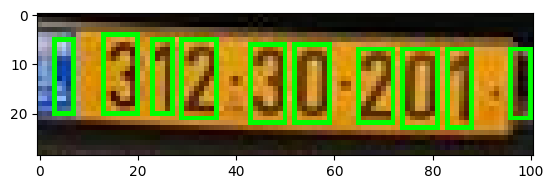

In [12]:
for plate in plates:
    hsv_masked = apply_hsv_mask(plate)
    thresh = apply_thresh(hsv_masked, 11)
    roi = get_new_roi(thresh, plate)
    roi_thresh = apply_adpt_thresh(roi, 3)
    conts, roi_conts = get_conts(roi_thresh, roi)
    digits, roi_boxes = get_bounding_boxes(conts, roi)
    # FIND DOMINATED COLOR IN BOX PLESASEEEEEEEEEEEEEEEEEEEE
    plt.imshow(cv2.cvtColor(roi_boxes, cv2.COLOR_BGR2RGB))

# Recognizing digits

In [24]:
model = tf.keras.models.load_model(r"Digits2.keras")  # Loading model

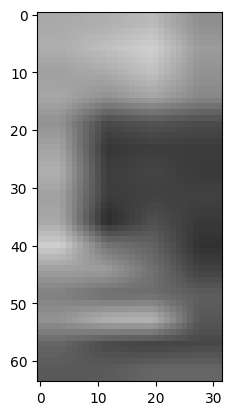

ValueError: in user code:

    File "C:\Users\sasso\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\sasso\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sasso\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\sasso\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "C:\Users\sasso\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\sasso\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 32, 64, 3), found shape=(None, 64, 32, 3)


In [25]:
h = 64
w = 32
digs = []
for digit in digits:
    img = cv2.resize(digit, (w, h))
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    img = img.convert("RGB")
    # img = img.resize((h, w))
    # print(img.size)
    plt.imshow(img)
    plt.show()
    img_array = img_to_array(img)
    img_array /= 255.0
    img_batch = np.expand_dims(img_array, axis=0) 
    
    predictions = model.predict(img_batch)
    
    prediction = np.argmax(predictions, axis=1)[0]
    digs.append(prediction)

In [21]:
number = "".join(str(dig) for dig in digs)

# Putting it on the original image

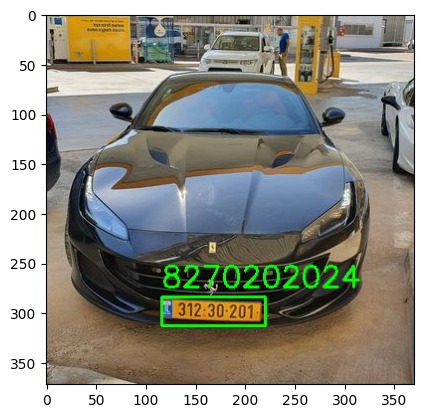

In [22]:
cop = cv2.cvtColor(orig_img.copy(), cv2.COLOR_BGR2RGB)
cv2.rectangle(cop, (startX, startY), (endX, endY), (0, 255, 0), 2)
cv2.putText(cop, number, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

plt.imshow(cop)